In [1]:
import os
import pandas as pd
from mplsoccer.pitch import Pitch, VerticalPitch
import numpy as np
from scipy.stats import binned_statistic_2d
np.random.seed(777)

In [2]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

In [3]:
# Pitch for binning the data
pitch = VerticalPitch(pitch_type='uefa', figsize=(16, 12), #pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)

In [4]:
# Bin the data into roughly 2 metre squaresm
pitch_range = [[pitch.dim.left, pitch.dim.right], [pitch.dim.bottom, pitch.dim.top]]
result = binned_statistic_2d(df.x, df.y, values=df.x, statistic='count', bins=(53, 34), expand_binnumbers=True,
                             range=pitch_range)

In [5]:
# Identify outliers
result_percent = binned_statistic_2d(df.x, df.y, values=df.goal, statistic='mean', bins=(53, 34),
                                     expand_binnumbers=True,
                                     range=pitch_range)
xdim_outlier, ydim_outlier = ((np.nan_to_num(result_percent.statistic) >= 0.08) & (result.statistic < 20)).nonzero()
df_bins = pd.DataFrame({'bin_x': xdim_outlier + 1, 'bin_y': ydim_outlier + 1})
df['bin_x'] = result_percent.binnumber[0, :]
df['bin_y'] = result_percent.binnumber[1, :]
df_bins['outlier'] = True
df = df.merge(df_bins, on=['bin_x', 'bin_y'], how='left')

In [6]:
# Generate some random data coordinates
x = np.arange(0, 105, 0.1)
y = np.arange(0, 68, 0.1)
x_random = np.random.choice(x, size=71400, replace=True)
y_random = np.random.choice(y, size=71400, replace=True)

In [7]:
# Bin the random coordinates
result_random = binned_statistic_2d(x_random, y_random, values=x_random, statistic='count', bins=(53, 34),
                                    expand_binnumbers=True, range=pitch_range)
df_fake = pd.DataFrame({'x': x_random, 'y': y_random})
df_fake['bin_x'] = result_random.binnumber[0, :]
df_fake['bin_y'] = result_random.binnumber[1, :]

In [8]:
# Keep only data in the fake data coordinates where there are fewer than 100 shots in the square
x_dim, y_dim = (result.statistic < 100).nonzero()
df_bins_to_add = pd.DataFrame({'bin_x': x_dim + 1, 'bin_y': y_dim + 1})
df_fake = df_fake.merge(df_bins_to_add, how='inner', on=['bin_x', 'bin_y'])

In [9]:
# Remove the area infront of the goals
mask_infront_goal = (df_fake.bin_x > 52) & (df_fake.bin_y > 13) & (df_fake.bin_y < 22)
df_fake = df_fake[~mask_infront_goal].copy()

In [10]:
# Remove area close to defensive goal (first 18 squares)
mask_defence = (df_fake.bin_x < 18)
df_fake = df_fake[~mask_defence].copy()

In [11]:
# Keep area inside the penalty box
mask_pen_area = (df_fake.bin_x > 45) &  (df_fake.bin_x < 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
mask_tight = (df_fake.bin_x == 53) & (df_fake.bin_y > 7) & (df_fake.bin_y < 28)
df_fake['tight'] = mask_tight
df_fake['pen_area'] = mask_pen_area

In [12]:
# Sample 1000 of the fake shots
df_fake = df_fake[mask_tight | mask_pen_area].copy()
df_fake = df_fake.sample(1000)

In [13]:
# Calculate the average goal probability from these areas (around 4%)
grids = df_fake[['bin_x', 'bin_y', 'pen_area']].drop_duplicates()
df = df.merge(grids, how='left')
mean_other_shots = df[df.pen_area == True].goal.mean()
print(mean_other_shots)

0.0416988416988417


In [14]:
# If tight angle = No Goal
df_fake.loc[df_fake['tight'], 'goal'] = False

In [15]:
# Otherwise set to the percentage above
goal1 = df_fake[df_fake.pen_area].groupby(['bin_x', 'bin_y']).apply(lambda x: x.sample(frac=mean_other_shots))
goal_idx1 = goal1.drop(['bin_x', 'bin_y'], axis=1).reset_index().level_2
df_fake.loc[df_fake.index.isin(goal_idx1), 'goal'] = True
df_fake.loc[df_fake.goal.isnull(), 'goal'] = False
df_fake['goal'] = df_fake['goal'].astype(bool)
df_fake.reset_index(drop=True, inplace=True)

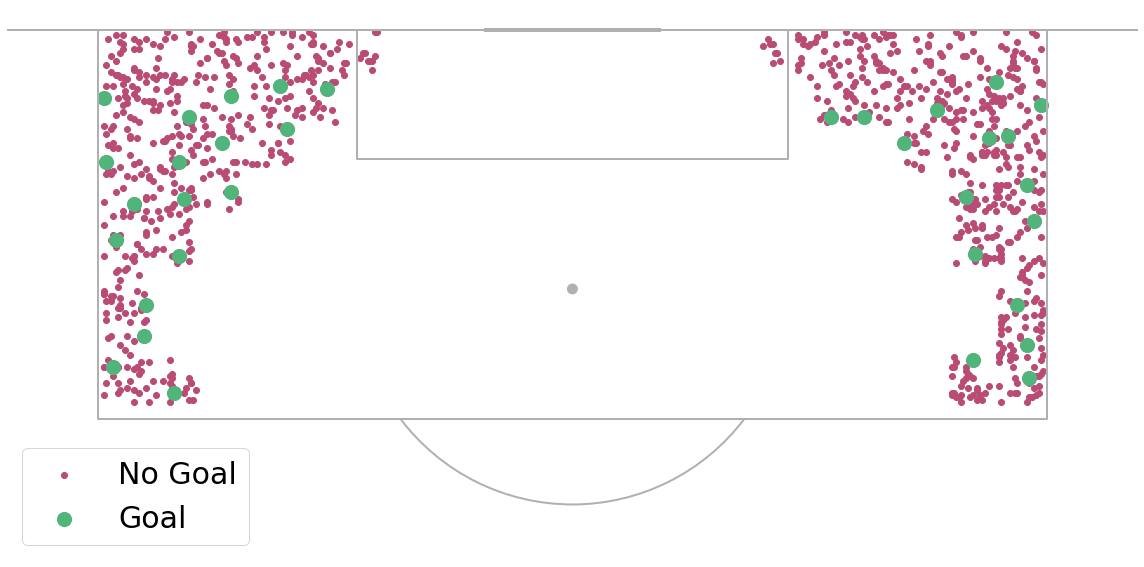

In [16]:
# Show areas with fake shots
pitch = VerticalPitch(pitch_type='uefa', pad_left=-10, pad_right=-10, pad_bottom=-30, pad_top=1,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
pitch.scatter(df_fake[~df_fake['goal']].x, df_fake[~df_fake['goal']].y, color='#b94b75', label='No Goal', ax=ax)
pitch.scatter(df_fake[df_fake['goal']].x, df_fake[df_fake['goal']].y, color='#50b47b', s=200, label='Goal', ax=ax)
ax.legend(fontsize=30)
fig.savefig(os.path.join(cwd, 'figures', '20_fake_data_added.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [17]:
cols_in_lgbm_model = ['shot_type_name', 'counter_attack', 'fast_break',
                       'strong_foot', 'body_part_name', 'assist_type', 'pass_end_y',
                       'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
                       'pass_height_name', 'pass_technique_name', 'carry_length',
                       'shot_one_on_one', 'shot_open_goal', 'under_pressure', 'area_shot', 'smart_pass',
                       'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y','match_week',
                       'H_A_column','players','players_rival','match_moment','shot_number','shot_zone_number',
                       'shot_player_number','shot_zone_player_number']

In [18]:
df_pen = df.loc[df.pen_area == True, cols_in_lgbm_model].copy()
df_pen

,shot_type_name,counter_attack,fast_break,strong_foot,body_part_name,assist_type,pass_end_y,pass_end_x,pass_switch,pass_cross,...,goalkeeper_y,match_week,H_A_column,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number
54,open_play,False,False,False,Right Foot,pass,46.835,91.9625,False,False,...,36.5,5.0,Home Team,11.0,11.0,0-15,1.0,1.0,1.0,1.0
61,open_play,False,False,False,Left Foot,pass,3.740,88.5500,True,False,...,42.7,6.0,Home Team,11.0,11.0,0-15,1.0,1.0,1.0,1.0
95,open_play,False,False,True,Right Foot,pass,62.050,61.2500,False,False,...,39.0,6.0,Away Team,11.0,11.0,0-15,1.0,1.0,1.0,1.0
128,free_kick,False,False,True,Right Foot,pass,49.300,91.0000,False,False,...,40.0,2.0,Home Team,11.0,11.0,0-15,1.0,1.0,1.0,1.0
131,open_play,False,False,True,Right Foot,pass,24.140,77.0875,False,False,...,43.1,16.0,Home Team,11.0,11.0,0-15,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65673,open_play,False,False,True,Right Foot,rebound,NaN,NaN,None,None,...,NaN,36.0,Away Team,11.0,11.0,75-90,10.0,2.0,1.0,1.0
65703,open_play,False,False,False,Left Foot,recovery,NaN,NaN,None,None,...,NaN,30.0,Home Team,11.0,11.0,75-90,9.0,4.0,1.0,1.0
65718,open_play,False,False,True,Right Foot,pass,NaN,NaN,False,False,...,NaN,26.0,Away Team,11.0,11.0,75-90,13.0,1.0,1.0,1.0
65731,open_play,True,True,True,Left Foot,pass,NaN,NaN,False,False,...,NaN,29.0,Away Team,11.0,11.0,75-90,21.0,6.0,2.0,1.0


In [19]:
df_pen = df_pen.sample(n=1000, replace=True).reset_index(drop=True)
df_pen

,shot_type_name,counter_attack,fast_break,strong_foot,body_part_name,assist_type,pass_end_y,pass_end_x,pass_switch,pass_cross,...,goalkeeper_y,match_week,H_A_column,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number
0,open_play,False,False,False,Left Foot,pass,NaN,NaN,False,False,...,NaN,20.0,Home Team,11.0,10.0,75-90,19.0,7.0,2.0,1.0
1,open_play,False,True,True,Left Foot,pass,48.28,87.0625,False,False,...,36.1,18.0,Away Team,11.0,11.0,60-75,6.0,2.0,1.0,1.0
2,open_play,False,False,False,Right Foot,pass,NaN,NaN,False,False,...,NaN,4.0,Away Team,11.0,11.0,60-75,9.0,1.0,3.0,1.0
3,throw_in,False,False,False,Left Foot,pass,NaN,NaN,False,False,...,NaN,6.0,Away Team,11.0,11.0,60-75,2.0,1.0,1.0,1.0
4,corner,False,False,False,Other,pass,43.35,99.4875,False,False,...,36.9,19.0,Away Team,11.0,11.0,0-15,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,open_play,False,False,True,Left Foot,pass,NaN,NaN,False,False,...,NaN,14.0,Away Team,11.0,11.0,75-90,14.0,2.0,2.0,1.0
996,open_play,False,False,False,Left Foot,pass,NaN,NaN,False,False,...,NaN,15.0,Home Team,11.0,11.0,45-60,5.0,1.0,2.0,1.0
997,open_play,False,False,False,Left Foot,pass,NaN,NaN,False,False,...,NaN,22.0,Away Team,11.0,11.0,30-45,2.0,1.0,1.0,1.0
998,open_play,False,False,True,Left Foot,pass,52.19,87.0625,False,False,...,36.8,32.0,Home Team,11.0,11.0,60-75,8.0,1.0,1.0,1.0


In [20]:
df_fake = df_fake.merge(df_pen, left_index=True, right_index=True)
df_fake

,x,y,bin_x,bin_y,tight,pen_area,goal,shot_type_name,counter_attack,fast_break,...,goalkeeper_y,match_week,H_A_column,players,players_rival,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number
0,102.1,46.9,52,24,False,True,False,open_play,False,False,...,NaN,20.0,Home Team,11.0,10.0,75-90,19.0,7.0,2.0,1.0
1,89.8,16.8,46,9,False,True,False,open_play,False,True,...,36.1,18.0,Away Team,11.0,11.0,60-75,6.0,2.0,1.0,1.0
2,103.9,44.9,53,23,True,False,False,open_play,False,False,...,NaN,4.0,Away Team,11.0,11.0,60-75,9.0,1.0,3.0,1.0
3,102.8,50.0,52,26,False,True,False,throw_in,False,False,...,NaN,6.0,Away Team,11.0,11.0,60-75,2.0,1.0,1.0,1.0
4,101.9,14.2,52,8,False,True,False,corner,False,False,...,36.9,19.0,Away Team,11.0,11.0,0-15,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,98.6,51.8,50,26,False,True,False,open_play,False,False,...,NaN,14.0,Away Team,11.0,11.0,75-90,14.0,2.0,2.0,1.0
996,104.4,43.5,53,22,True,False,False,open_play,False,False,...,NaN,15.0,Home Team,11.0,11.0,45-60,5.0,1.0,2.0,1.0
997,103.6,15.3,53,8,True,False,False,open_play,False,False,...,NaN,22.0,Away Team,11.0,11.0,30-45,2.0,1.0,1.0,1.0
998,103.0,21.7,52,11,False,True,False,open_play,False,False,...,36.8,32.0,Home Team,11.0,11.0,60-75,8.0,1.0,1.0,1.0


In [21]:
df_fake.drop(['bin_x', 'bin_y', 'tight', 'pen_area'], axis=1, inplace=True)

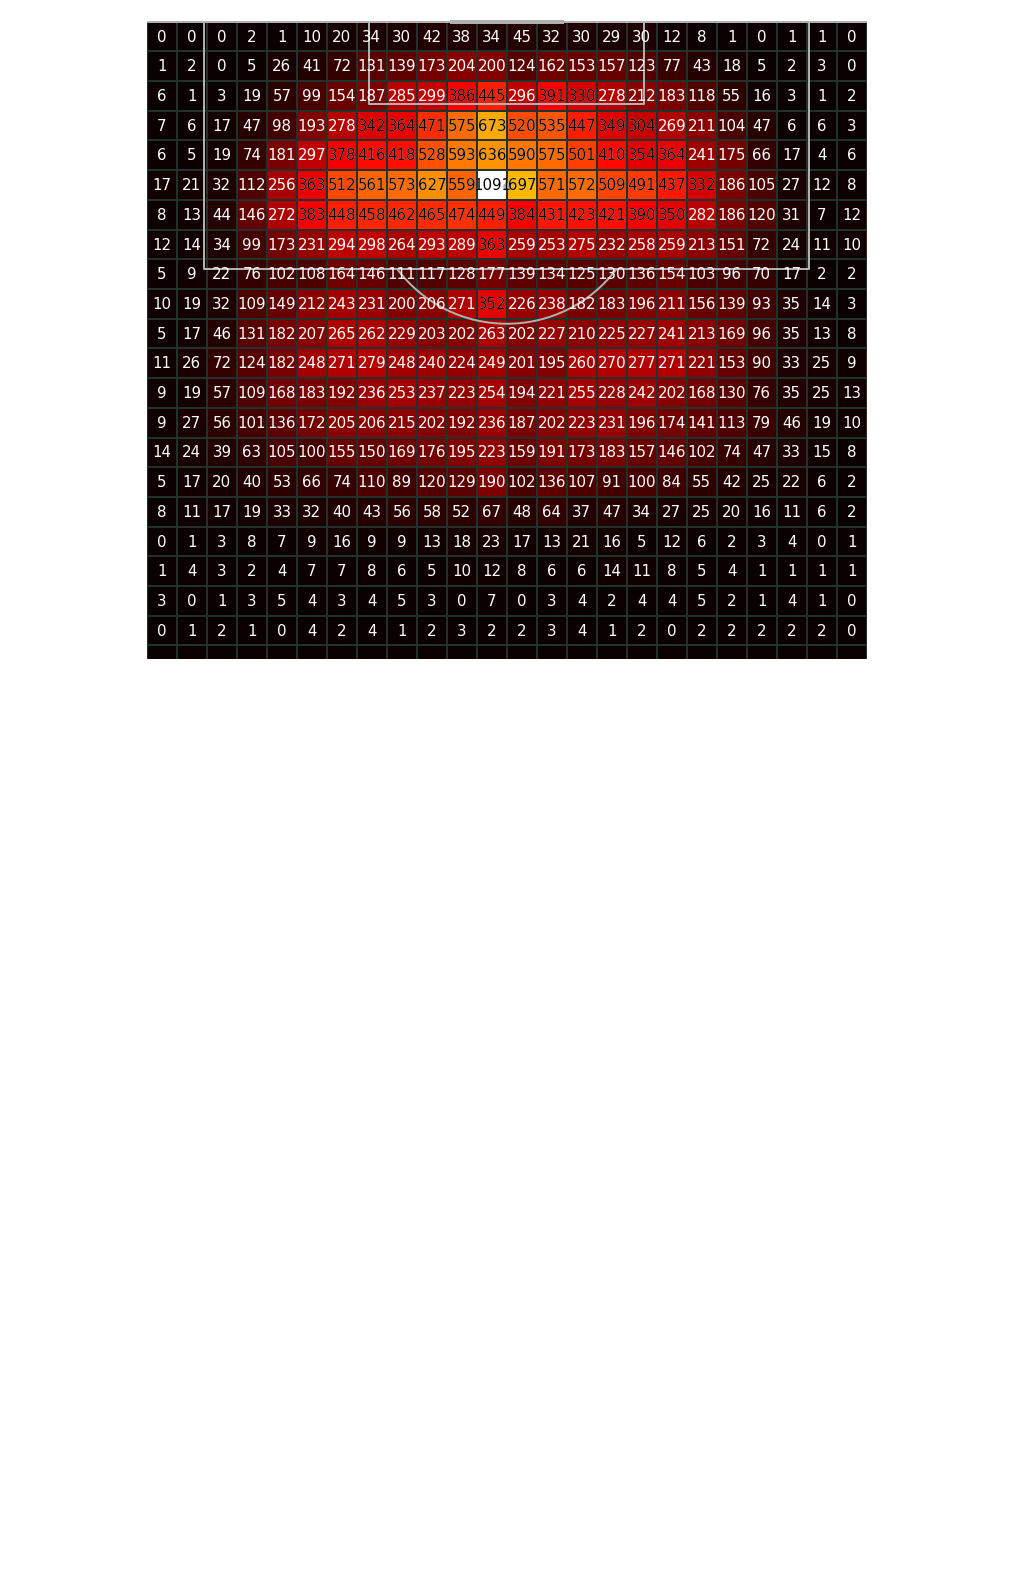

In [22]:
# Check before adding fake data. Less smooth
pitch = VerticalPitch(pitch_type='uefa', pad_left=-10, pad_right=-10, pad_bottom=-10, pad_top=1,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df.x, df.y, statistic='count', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '19_number_of_shots_by_location.png'), bbox_inches = 'tight', pad_inches = 0.2)

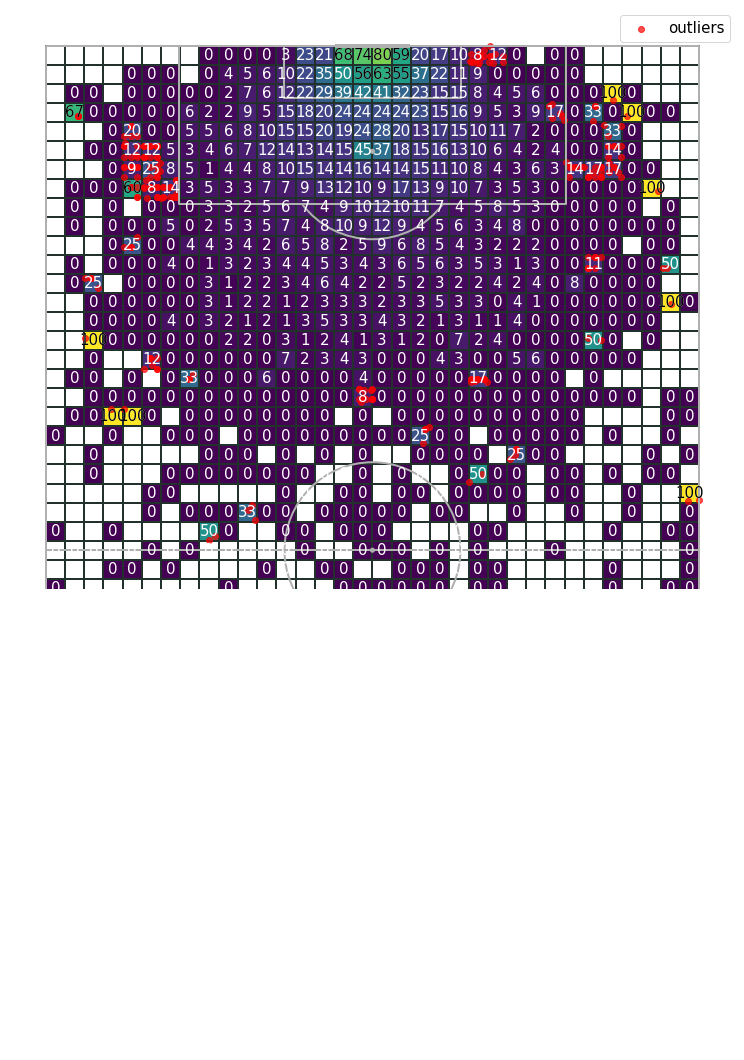

In [23]:
pitch = VerticalPitch(pitch_type='uefa', #pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df.x, df.y, values=df.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
pitch.scatter(df[df['outlier']==True].x, df[df['outlier']==True].y, ax=ax, color='red', label='outliers', alpha=0.7)
ax.legend(fontsize=15)
fig.savefig(os.path.join(cwd, 'figures', '18_outliers.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [24]:
# Check after adding fake data - scoring percentages
df_with_fake= pd.concat([df_fake[['x', 'y', 'goal']], df.loc[~(df.outlier == True), ['x', 'y', 'goal']]])
df_with_fake

,x,y,goal
0,102.10,46.90,False
1,89.80,16.80,False
2,103.90,44.90,False
3,102.80,50.00,False
4,101.90,14.20,False
...,...,...,...
65783,91.35,46.92,False
65784,93.45,34.00,False
65785,92.40,27.20,False
65786,93.45,20.40,False


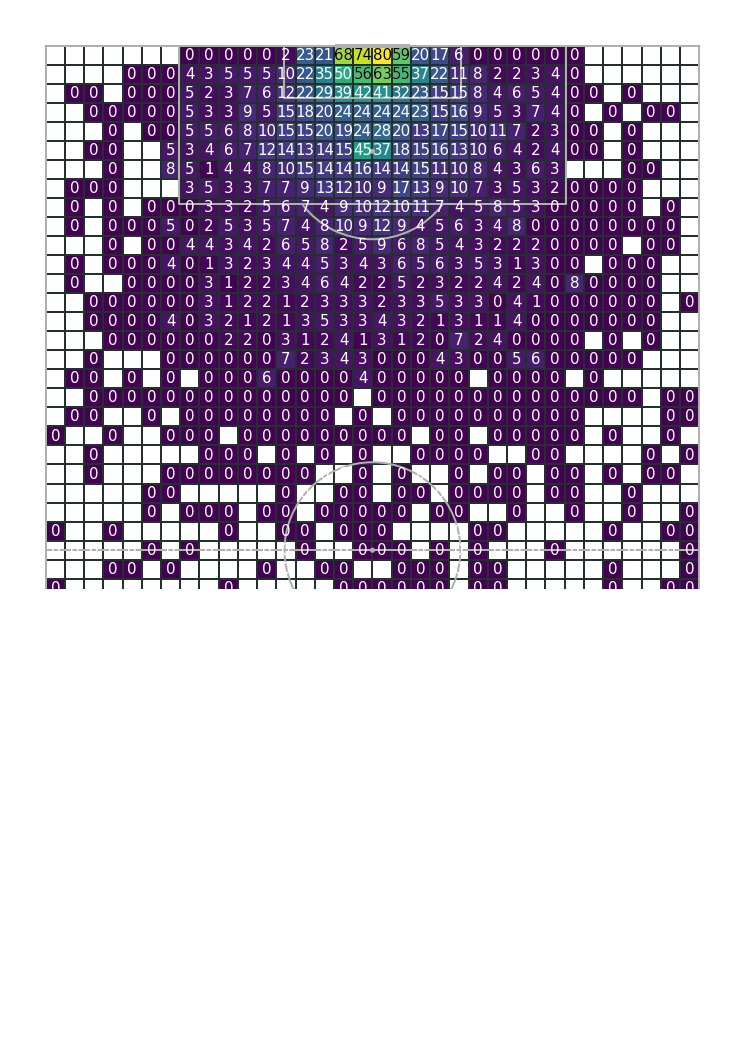

In [25]:
pitch = VerticalPitch(pitch_type='uefa', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df_with_fake.x, df_with_fake.y, values=df_with_fake.goal,  statistic='mean', bins=(53, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = np.round(bs['statistic'] * 100., 0).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 50
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '21_raw_goal_probabilities_with_fake_and_removing_outliers.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

In [26]:
# Save fake data
df_fake.to_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))

In [27]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   x                        1000 non-null   float64
 1   y                        1000 non-null   float64
 2   goal                     1000 non-null   bool   
 3   shot_type_name           1000 non-null   object 
 4   counter_attack           1000 non-null   bool   
 5   fast_break               1000 non-null   bool   
 6   strong_foot              1000 non-null   bool   
 7   body_part_name           1000 non-null   object 
 8   assist_type              1000 non-null   object 
 9   pass_end_y               250 non-null    float64
 10  pass_end_x               250 non-null    float64
 11  pass_switch              718 non-null    object 
 12  pass_cross               718 non-null    object 
 13  pass_cut_back            718 non-null    object 
 14  pass_height_name         

In [28]:
# Save shot dataset. Remove outliers and extra columns
print('Outliers removed;', df.outlier.notnull().sum())
df = df[df.outlier.isnull()].copy()
df.drop(['bin_x', 'bin_y', 'outlier', 'pen_area'], axis=1, inplace=True)
df

Outliers removed; 228


,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,penalty_number
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,None,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,None,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,None,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,None,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,None,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65783,2499739,None,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,1659.0,9277.0,None,75-90,Zone 4,9.0,4.0,1.0,1.0,1.0
65784,2499820,None,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,1644.0,7929.0,None,75-90,Zone 4,11.0,5.0,1.0,1.0,1.0
65785,2516750,None,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,2463.0,127685.0,False,75-90,Zone 4,17.0,3.0,2.0,1.0,14.0
65786,2499820,None,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,1623.0,145692.0,False,75-90,Zone 4,9.0,5.0,2.0,1.0,5.0


In [29]:
df.to_parquet(os.path.join(cwd, 'data', 'shots.parquet'))